In [1]:
!pip install tensorflow==2.15.0 --ignore-installed


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for tensorflow==2.15.0 from https://files.pythonhosted.org/packages/93/c0/a774286d0383419f558deb27096e5de9f9facd6c27df8e9f9af6fba2f77e/tensorflow-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached tensorflow-2.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/f6/d4/349f7f4bd5ea92dab34f5bb0fe31775ef6c311427a14d5a5b31ecb442341/absl_py-2.2.2-py3-none-any.whl.metadata
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)

In [3]:
!pip install tensorflow==2.15.0 numpy==1.26.4 matplotlib==3.8.2 scikit-learn==1.4.2 seaborn==0.13.2 pandas==2.2.1 scipy==1.12.0


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import os
import zipfile
import random
import shutil
from pathlib import Path

2025-04-16 22:17:06.902130: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 22:17:07.017201: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 22:17:07.017283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 22:17:07.026282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 22:17:07.076923: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-16 22:17:07.077758: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# Define the zip file name and the directory to extract to
#Naylor Specific path:
zip_path = "american-sign-language-letters-subdir.zip"  # replace with your actual zip filename
extract_to = "data"  # or any folder name you want

import os
print(os.getcwd())

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted '{zip_path}' to '{extract_to}/'")

/sfs/gpfs/tardis/home/pdx9sq/Desktop/DS_4002_DataX_3/SCRIPTS
Extracted 'american-sign-language-letters-subdir.zip' to 'data/'


In [4]:
# Original dataset folder
SOURCE_DIR = "data/subdir"
# Output directories
TRAIN_VAL_DIR = "data/train_val"
TEST_DIR = "data/test"
# Test split ratio
TEST_SPLIT = 0.15  # 15% of images per class go to test

# Create target dirs if they don't exist
os.makedirs(TRAIN_VAL_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Seed for reproducibility
random.seed(42)

# Loop through each class folder (A, B, C, ...)
for class_name in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    # List image files in the class folder
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg"))]
    random.shuffle(image_files)

    # Calculate how many to move to test
    test_count = int(len(image_files) * TEST_SPLIT)
    print(test_count)

    # Define class folders in new dirs
    train_val_class_dir = os.path.join(TRAIN_VAL_DIR, class_name)
    test_class_dir = os.path.join(TEST_DIR, class_name)
    os.makedirs(train_val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Move files to test and train_val
    for i, file_name in enumerate(image_files):
        src_path = os.path.join(class_path, file_name)
        if i < test_count:
            dst_path = os.path.join(test_class_dir, file_name)
        else:
            dst_path = os.path.join(train_val_class_dir, file_name)
        shutil.copy2(src_path, dst_path)

print(test_count)


8
10
8
9
10
10
8
10
9
9
11
10
9
10
9
9
8
9
13
7
7
12
11
11
9
11
11


In [5]:
#image information
data_dir = "data/subdir"
img_height, img_width = 64, 64
batch_size = 32

In [6]:
# Load raw images and split, better practice to clean after split

# Train/validation split from train_val folder
train_val_dir = "data/train_val"
test_dir = "data/test"

# Training set
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)

# Validation set
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_val_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)

# Test set — loaded from separate folder
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)

Found 1481 files belonging to 26 classes.
Using 1185 files for training.
Found 1481 files belonging to 26 classes.
Using 296 files for validation.
Found 247 files belonging to 26 classes.


2025-04-16 22:17:35.136479: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Preprocessing function: grayscale + normalize scales image of pixels
def preprocess(image, label):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


In [8]:
# Apply preprocessing to train and test ds
train_ds = raw_train_ds.map(preprocess)
val_ds = raw_val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

In [9]:
#new stuff

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
#uses float16 for fast training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Input
#builds a lightweight convolutional neural network (CNN)

#defines the shape of the model, a 64x64 grayscale 
# the model then takes each ASL sign image and extracts features using efficient convolutional layers
#Reduces dimensions of image using global pooling
#Learns final patterns with Dense layers
#outputs a probability for each letter (A–Z + space)
model = Sequential([
    Input(shape=(64, 64, 1)),  # 1 channel because grayscale

    SeparableConv2D(32, 3, activation='relu'), #building a light weight model
    BatchNormalization(), #normalizes the outputs
    SeparableConv2D(128, 3, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling2D(),

    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(27, activation='softmax', dtype='float32')  # 26 letters + maybe 1 for "space"
])


In [12]:
#compile the model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separabl  (None, 62, 62, 32)        73        
 eConv2D)                                                        
                                                                 
 batch_normalization (Batch  (None, 62, 62, 32)        128       
 Normalization)                                                  
                                                                 
 separable_conv2d_1 (Separa  (None, 60, 60, 128)       4512      
 bleConv2D)                                                      
                                                                 
 batch_normalization_1 (Bat  (None, 60, 60, 128)       512       
 chNormalization)                                                
                                                                 
 global_average_pooling2d (  (None, 128)               0

In [ ]:
#train the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=30, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=30, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
38/38 [==============================] - 205s 5s/step - loss: 3.0976 - accuracy: 0.1097 - val_loss: 3.2840 - val_accuracy: 0.0439 - lr: 9.4559e-04
Epoch 2/50
38/38 [==============================] - 205s 5s/step - loss: 3.0748 - accuracy: 0.1114 - val_loss: 3.2821 - val_accuracy: 0.0439 - lr: 9.4181e-04
Epoch 3/50
38/38 [==============================] - 205s 5s/step - loss: 3.0580 - accuracy: 0.1224 - val_loss: 3.2866 - val_accuracy: 0.0439 - lr: 9.3805e-04
Epoch 4/50
38/38 [==============================] - 203s 5s/step - loss: 3.0263 - accuracy: 0.1333 - val_loss: 3.2787 - val_accuracy: 0.0439 - lr: 9.3430e-04
Epoch 5/50
38/38 [==============================] - 203s 5s/step - loss: 3.0092 - accuracy: 0.1376 - val_loss: 3.2629 - val_accuracy: 0.0507 - lr: 9.3057e-04
Epoch 6/50
38/38 [==============================] - 203s 5s/step - loss: 2.9875 - accuracy: 0.1451 - val_loss: 3.2345 - val_accuracy: 0.0574 - lr: 9.2685e-04
Epoch 7/50
38/38 [==============================] - 

In [1]:
#evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")


NameError: name 'model' is not defined

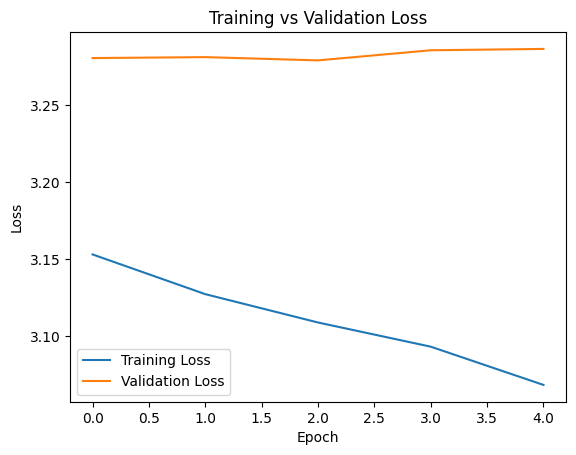

In [19]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()